# UK Commerce 데이터를 이용한 리포트 작성

## 데이터 생성

* 이전에 다운받아놓은 dataset3 이용

## 국가별, 상품별 구매자 수 및 매출액

* country, stockcode로 데이터를 그룹핑하고, 고객 번호를 카운트, 구매 상품 수 * 개당 가격의 곱을 합하면 된다.
* 유의할 점은 고객 번호가 중복 없는 데이터인지 확인하는 것이다.

In [ ]:
# 국가별, 상품별 구매자 수 및 매출액
SELECT Country, StockCode, COUNT(DISTINCT CustomerID) BU,
SUM(Quantity * UnitPrice) Sales
FROM dataset3
GROUP BY 1, 2
ORDER BY 3 DESC, 4 DESC;

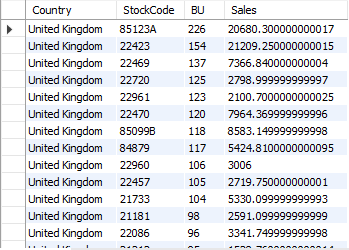

## 특정 상품 구매자가 많이 구매한 상품은?

* 장바구니 분석의 핵심은 고객의 구매 내역을 보고 상품과 상품 사이에 상관관계가 있는지 확인하는 것이다.
* 맥주를 구매할 경우, 기저귀를 구매하는 경향이 있는지 아니면 기저귀를 구매하지 않는 경향이 있는지와 같은 연관성을 파악할 수 있다.
* UK Commerce 데이터 세트를 이용해 특정 상품을 구매한 구매자가 어떤 상품을 많이 구매하는지 알아보려면 먼저 가장 많이 판매된 Top2 상품을 모두 구매한 고객이 구매한 상품 코드를 조회한다.
* 절차는 다음과 같이 가장 많이 판매된 상품의 상품 코드를 파악하는 것부터 시작된다.

### 1. 가장 많이 판매된 2개 상품 조회(판매 상품 수 기준)

* 먼저 상품별로 판매된 개수를 구한다.

In [ ]:
# 상품별로 판매된 개수
SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
GROUP BY 1;

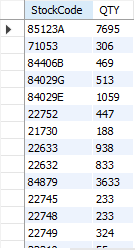

* 다음으로 판매된 상품 수 기준으로 랭크를 생성한다.
* 가장 많이 판매된 2개의 상품을 조회하는 것이 목적이므로 내림차순으로 순위를 매긴다.
* 위 쿼리를 서브쿼리로 만들어 랭크를 생성하면 된다.

In [ ]:
# 상품 수 기준으로 랭크를 생성
SELECT *,
ROW_NUMBER() OVER(ORDER BY QTY DESC) RNK
FROM
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
GROUP BY 1) A;

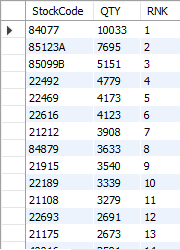

* 해당 테이블에서 랭크가 1, 2인 데이터를 조회하면 된다.
* 위의 쿼리를 다시 서브퀄리로 다시 생성해 WHERE절을 생성하고 조건을 만든다.

In [ ]:
# 랭크가 1, 2인 데이터를 조회
SELECT StockCode
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY QTY DESC) RNK
FROM
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
GROUP BY 1) A) A
WHERE RNK BETWEEN 1 AND 2;

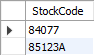

* 서브 쿼리를 연습하기 위해 다소 복잡하게 작성했으나, 실제 쿼리 작성 시엔 ORDER BY나 더 간단한 방법을 사용하여 작성해도 상관없다.

### 2. 가장 많이 판매된 2개 상품을 모두 구매한 구매자가 구매한 상품

* 2개 상품을 모두 구매한 고객이 구매한 상품별 주문 건수를 계산하고자 한다.
* 먼저 고객별로 각각의 상품을 구매한다면 1, 그렇지 않다면 0이 출력되도록 쿼리를 작성하고, 각 상품을 모두 구매한 경우만 출력되도록 HAVING을 통해 조건을 생성한다.

In [ ]:
# 2개 상품을 모두 구매한 고객이 구매한 상품별 주문 건수 계산
CREATE TABLE BU_List AS
SELECT CustomerID
FROM dataset3
GROUP BY 1
HAVING MAX(CASE WHEN StockCode = '84077' THEN 1 ELSE 0 END) = 1
AND MAX(CASE WHEN StockCode = '85123A' THEN 1 ELSE 0 END) = 1;

* 2가지 84077, 85123A 상품을 모두 구매한 고객 번호를 출력했다.
* 해당 고객들이 구매한 상품을 출력하기 위해 IN 연산자를 이용하여 해당 고객들이 구매한 상품번호를 조회한다.

In [ ]:
# 해당 고객들이 구매한 상품 출력
SELECT DISTINCT StockCode
FROM dataset3
WHERE CustomerID IN(SELECT CustomerID FROM BU_List)
AND StockCode NOT IN ('84077', '85123A');

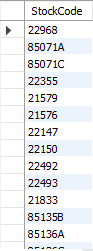

## 국가별 재구매율 계산

* 국가별로 재구매 현황이 다르므로 재구매율을 구하기 위해선 테이블에서 InvoiceDate의 연도를 각각 1씩 차감한 뒤 CustomerID, InvoiceDate, Country로 조인하면 해당 연도에 구매한 경우에는 데이터가 결합하고, 그렇지 않은 경우는 결합하지 않는다.
* 위의 결합 결과에서 연도, 국가별로 CustomerID1을 Count하면 해당 연도의 국가별 구매자 수가 되고, CustomerID2를 Count하면 차년도에도 연속으로 구매한 구매자 수를 계산할 수 있다.

In [ ]:
# 국가별 재구매율 계산
SELECT A.Country, SUBSTR(A.InvoiceDate, 1, 4) YY, COUNT(DISTINCT B.CustomerID)/COUNT(DISTINCT A.CustomerID) Retention_Rate
FROM
(SELECT DISTINCT Country, InvoiceDate, CustomerID FROM dataset3) A
LEFT JOIN (SELECT DISTINCT Country, InvoiceDate, CustomerID
FROM dataset3) B
ON SUBSTR(A.InvoiceDate, 1, 4) = SUBSTR(B.InvoiceDate, 1, 4) -1
AND A.Country = B.Country
AND A.CustomerID = B.CustomerID
GROUP BY 1, 2
ORDER BY 1, 2;

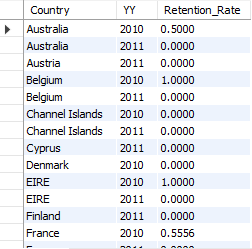

## 코호트 분석

* 코호트 분석을 통해 특정 기간에 구매한 또는 가입한 고객들의 이후 구매액 및 리탠션을 확인해본다.

### 코호트 분석
* 시간 흐름에 따라 사용자의 리텐션, 구매 패턴, 행동 패턴을 파악하는 데 사용되는 분석
* 보통 첫 구매 월, 가입 월, 구매 월 기준으로 시간의 흐름에 따른 변화를 살펴본다.
* 여기선 첫 구매 월을 기준으로 각 그룹 간의 패턴을 파악해보기 위해 먼저 고객별로 첫 구매일을 구한다.

In [ ]:
# 고객별로 첫 구매일 조회
SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1;

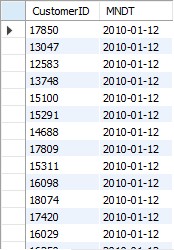

* 고객별 첫 구매일을 구한 다음, 각 고객의 주문 일자, 구매액을 조회한다.

In [ ]:
# 각 고객의 주문 일자, 구매액 조회
SELECT CustomerID, InvoiceDate, UnitPrice*Quantity Sales
FROM dataset3;

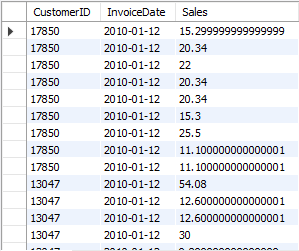

* 첫 번째로 구매했던 고객별 첫 구매일 테이블에 고객의 구매 내역을 join한다.

In [ ]:
# 첫 번째로 구매했던 고객별 첫 구매일 테이블에 고객의 구매 내역 join
SELECT *
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1) A
LEFT JOIN
(SELECT CustomerID, InvoiceDate, UnitPrice*Quantity Sales
FROM dataset3) B
ON A.CustomerID = B.CustomerID;

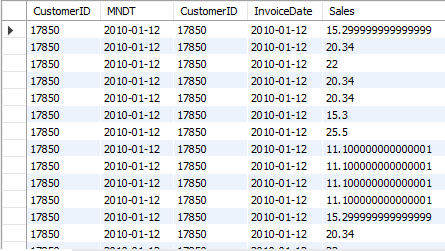

* 조인을 통해 코호트 분석을 위한 테이블을 생성했다.
* 분석을 위한 데이터 형태에는 DATEDIFF, SALES에 대한 컬럼을 추가해야 하므로 다음과 같이 쿼리를 작성하여 계산한다.

In [ ]:
# 분석을 위한 데이터 컬럼 계산
SELECT SUBSTR(MNDT, 1, 7) MM, TIMESTAMPDIFF(MONTH, MNDT, InvoiceDate) DATEDIFF,
COUNT(DISTINCT A.CustomerID) BU, SUM(Sales) Sales
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1) A
LEFT JOIN
(SELECT CustomerID, InvoiceDate, UnitPrice*Quantity Sales
FROM dataset3) B
ON A.CustomerID = B.CustomerID
GROUP BY 1, 2;

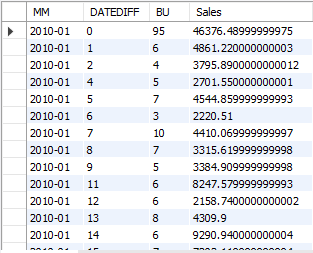

* 최초 구매일은 SUBSTR()함수를 이용해 '연도-월'까지만 데이터를 가져온다.
* 이후 최초 구매일과 각 구매일 사이의 간격은 TIMSTAMPDIFF()함수를 이용하여 계산한다.
* 이후 최초 구매월, 구매 간격으로 그룹핑해 구매자 수를 카운트하고, 매출을 합계해 각 코호트의 래텐션과 매출액을 구할 수 있다.

## 고객 세그먼트

### 1. RFM
* 서비스에서 높은 가치를 가진 고객을 구분하기 위해 자주 사용되는 모델

#### a. RFM
* RFM은 가치 있는 고객을 추출해 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서 유용하게 사용될 수 있는 방법, 마케팅분야에서 가장 많이 사용되는 방법론
* 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석 방법, 분석 과정을 통해 데이터는 의미 있는 정보로 전환
* Recency, Frequency, Monetary의 약자, 다음 세 가지 기준에 의해 계산
    - Recency: 제일 최근에 구입한 시기가 언제인가?
    - Frequency: 어느 정도로 자주 구입했나?
    - Monetary: 구입한 총 금액은 얼마인가?

* Recency는 거래의 최근성을 나타내는 지표로, 고객이 얼마나 최근에 구입했는지를 의미함
* 보통 산출하는 시점을 기준으로 하여 며칠 또는 몇 달 전에 구매했는지 계산
* 해당 데이터 세트의 마지막 구매일은 2011-12-01로, 우리는 2011-12-02을 기준으로 하여 Recency를 계산해본다.
* 먼저 고객의 마지막 구매일을 구한다.

In [ ]:
# 고객의 마지막 구매일 조회
SELECT CustomerID, MAX(InvoiceDate) MXDT
FROM dataset3
GROUP BY 1;

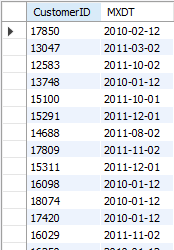

* 이후, 2011-12-02로부터의 Timer Interval을 계산한다.

In [ ]:
# 2011-12-02로부터의 Timer Interval 계산
SELECT CustomerID, DATEDIFF('2011-12-02', MXDT) Recency
FROM
(SELECT CustomerID, MAX(InvoiceDate) MXDT
FROM dataset3
GROUP BY 1) A;

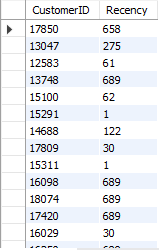

* 이어서 Frequency와 Monetary를 계산한다. Frequency는 구매 건수로, Monetary는 구매 금액으로 계산할 수 있다.

In [ ]:
# Frequency와 Monetary를 계산
SELECT CustomerID, COUNT(DISTINCT InvoiceNo) Frequency,
SUM(Quantity*UnitPrice) Monetary
FROM dataset3
GROUP BY 1;

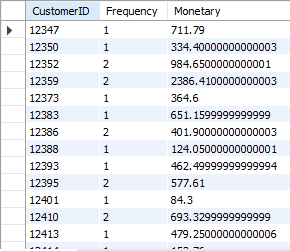

* 위에서 구한 Recency, Frequency, Monetary를 하나의 쿼리로 구한다.

In [ ]:
# Recency, Frequency, Monetary를 하나의 쿼리로 구현
SELECT CustomerID, DATEDIFF('2011-12-02', MXDT) Recency,
Frequency, Monetary
FROM
(SELECT CustomerID, MAX(InvoiceDate) MXDT, COUNT(DISTINCT InvoiceNo) Frequency,
SUM(Quantity*UnitPrice) Monetary
FROM dataset3
GROUP BY 1) A;

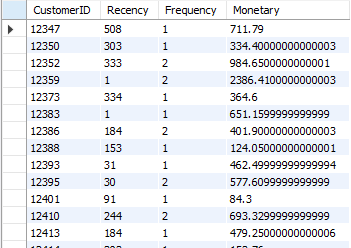

* 계산한 RFM Score를 이용하여 세그먼트를 나누기 위해선 K-Means 알고리즘과 같은 클러스터링 기법으로 고객군을 나눌 수 있다.

#### b. K Meanx 알고리즘
* 비슷한 특성을 가진 데이터를 그룹필하는 클러스터링 기법

### 2. 재구매 Segment

* 동일한 상품을 2개 연도에 걸쳐서 구매한 고객과 그렇지 않은 고객을 Segment로 나누려면 어떻게 해야 할까? 즉 A라는 상품을 2010년도와 2011년에 걸쳐 구매한 고객과 A라는 상품을 특정 연도에만 구매한 고객으로 나눌 수 있을까?를 해결하고자 한다.
* 이를 구하기 위해서 먼저 고객별, 상품별 구매 연도를 Unique하게 카운트한다.

In [ ]:
# 고객별, 상품별 구매 연도를 Unique하게 카운트
SELECT CustomerID, StockCode, COUNT(DISTINCT SUBSTR(InvoiceDate, 1, 4)) Unique_YY
FROM dataset3
GROUP BY 1, 2;

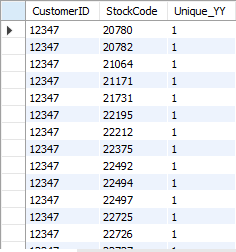

* Unique_YY가 2이상인 고객과 그렇지 않은 고객을 구분하면, 우리가 구하려고 했던 세그먼트를 구할 수 있다.
* 고객별로 Unique_YY의 최댓값을 계산했을 때, 그 값이 2 이상인 고객은 특정 상품을 2개 연도에 걸쳐 구매한 것으로 볼 수 있고, 그렇지 않은 고객은 연도에 걸쳐 재구매한 상품이 없다고 볼 수 있다.

In [ ]:
# 고객별로 Unique_YY의 최댓값을 계산
SELECT CustomerID, MAX(Unique_YY) MX_Unique_YY
FROM
(SELECT CustomerID, StockCode, COUNT(DISTINCT SUBSTR(InvoiceDate, 1, 4)) Unique_YY
FROM dataset3
GROUP BY 1, 2) A
GROUP BY 1;

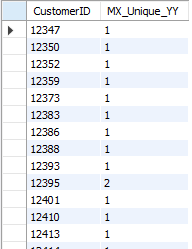

* MX_Unique_YY가 2 이상인 경우는 1로, 그렇지 않은 경우는 0으로 설정해 repurchase_segment를 생성한다.

In [ ]:
# MX_Unique_YY가 2 이상인 경우는 1로, 그렇지 않은 경우는 0으로 설정해 repurchase_segment를 생성
SELECT CustomerID, CASE WHEN MX_Unique_YY >= 2 THEN 1 ELSE 0 END repurchase_segment
FROM
(SELECT CustomerID, MAX(Unique_YY) MX_Unique_YY
FROM
(SELECT CustomerID, StockCode, COUNT(DISTINCT SUBSTR(InvoiceDate, 1, 4)) Unique_YY
FROM dataset3
GROUP BY 1, 2) A
GROUP BY 1) A
GROUP BY 1;

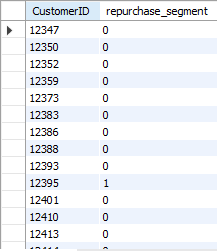

## 일자별 첫 구매자 수

* 일자별 첫 구매자 수를 구하고자 한다. 예를 들어 2006-01-01에 첫 구매한 고객 수는 몇 명인지, 2006-01-02에 첫 구매한 고객 수는 몇 명인지 구해본다.
* 먼저 고객별로 첫 구매일을 계산하고 일자별로 고객 수를 카운트하면, 일자별 첫 구매자 수를 계산할 수 있다.

### 1. 고객별 첫 구매일

In [ ]:
# 고객별 첫 구매일
SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY CustomerId;

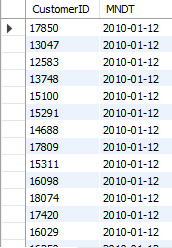

* 일자별로 고객 수를 카운트하면, 일자별 첫 구매 고객 수르르 계산할 수 있다.

### 2. 일자별 첫 구매 고객 수

In [ ]:
# 일자별 첫 구매 고객 수
SELECT MNDT, COUNT(DISTINCT CustomerID) BU
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY CustomerId) A
GROUP BY MNDT;

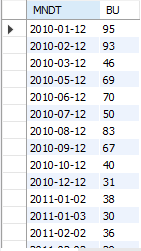